In [99]:
# Standard imports
import numpy as np
import pandas as pd
import itertools
from warnings import filterwarnings
import matplotlib.pyplot as plt

# Loading sklearn functionality from prior lessons
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder

# Important functionality for this lesson
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
from ipywidgets import interactive
import ipywidgets as widgets


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
from warnings import filterwarnings
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Loading sklearn functionality 
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, VarianceThreshold, f_classif, f_regression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder

# Important functionality for this lesson ---> Statistical tools for model building etc
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

#plotting
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# Global plotting parameters
plt.rcParams['figure.figsize'] = (12, 4)
plt.rcParams["axes.grid"] = True

# Brand colors dictionary
brand_colors = {
    "Denim": "#1358DB",
    "Supernova": "#FFCF00",
    # "Black": "#000000",
    # "Dark Blue": "#101D42",
    # "White": "#FFFFFF",
    "Dark Gray": "#6F6F6F",
    # "Light Gray 1": "#F6F6F4",
    "Light Gray 2": "#ADBDCC"
}

# Create a matplotlib colormap
brand_cmap = plt.cm.colors.ListedColormap(list(brand_colors.values()))
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=brand_colors.values())

"""
Note: Suppressing warnings is generally not recommended. 
Warnings are being ignored in this notebook to prevent unnecessary clutter
and improve readability while working through the lesson
"""
filterwarnings(action='ignore')

In [6]:
# Functions

def lag_scatterplot(df, column, lag):
    """
    Plots a scatterplot to visualize the relationship between a series and its lagged values
    over a specified time lag.

    Inputs
    --------------
    df: a pandas DataFrame containing the time series data.
    column: a string with the name of the column to be plotted.
    lag: an integer representing the lag in time steps by which the time series values are shifted.

    Outputs
    --------------
    Displays a scatterplot showing the relationship between time series values and their
    lagged values, with the calculated correlation coefficient shown in the plot title.
    """

    # calculating lag
    lagged_values = df[column].shift(lag)

    # calculating correlation
    correlation = df[column].corr(lagged_values).round(3)

    # plotting
    plt.figure()
    plt.scatter(df[column], lagged_values, alpha=0.1, s=40, color='darkblue', edgecolors='darkblue', linewidths=1.5)
    plt.title(f'Correlation: {correlation}')
    plt.ylabel(f'Monthly CO2 Levels (t+{lag})')
    plt.xlabel('Monthly CO2 Levels (t)')
    plt.show()

# Train/Test Split

In order to properly evaluate our models, we need to isolate our Train and Test set. In traditional machine learning  modeling, we generally take random samples of data points and have them randomly assigned to the corresponding sets. **This is not possible in Time Series because there is an order to time that we need to preserve**. In order to keep the sequential order of our data, we generally take a proportion of the most recent data points, and assign them to the Test set. We use the remainder points as our Train set.

First lets start by loading our data, we will use the daily average sampled data that we created in the previous notebook for preprocessing

In [53]:

power_df_monthly = pd.read_csv(r"C:\Users\karni\OneDrive\Desktop\GitHub\BrainStation_CapstoneProject\data\power_weather_monthly.csv",index_col='DateTime')

power_df_monthly.head()

,Energy Consumed by Household (Watt-hour),"Energy Consumed by Household excluding sub-meterings 1, 2 and 3 (Watt-hour)",Reactive Energy Consumed by Household (Watt-hour),Voltage (volts),Global_intensity (amperes),Sub_metering_1 (watt-hours of active energy),Sub_metering_2 (watt-hours of active energy),Sub_metering_3 (watt-hours of active energy),temperature_2m (°C),relative_humidity_2m (%),dew_point_2m (°C),apparent_temperature (°C),surface_pressure (hPa),cloudcover (%),windspeed_10m (km/h),windgusts_10m (km/h),winddirection_10m (degrees),shortwave_radiation (W/m²),direct_radiation (W/m²),diffuse_radiation (W/m²)
DateTime,,,,,,,,,,,,,,,,,,,,
2006-12-01,31.688252,20.815071,2.189763,241.441125,8.029956,1.248636,2.214987,7.409558,2.665667,89.373203,1.035962,-1.077252,1020.453060,69.210094,12.331461,23.786715,122.629084,34.024386,14.111747,19.912639
2007-01-01,25.767232,15.343714,2.211268,240.905101,6.546915,1.264237,1.775931,7.383351,7.207161,84.024638,4.577192,3.423857,1010.176016,82.074769,17.715948,35.031811,211.768246,38.132655,15.181784,22.950871
2007-02-01,23.351392,13.865257,1.893946,240.519390,5.914569,1.180217,1.602361,6.703557,7.549305,82.832249,4.651629,3.992242,999.810829,79.073664,15.637397,31.425021,194.193422,73.579543,38.948361,34.631182
2007-03-01,21.977117,11.764254,1.912447,240.513469,5.572979,1.361343,2.346872,6.504648,7.257748,79.442310,3.707103,3.849526,1005.630479,59.874198,13.452050,27.374541,215.718411,124.956769,71.833233,53.123536
2007-04-01,14.853149,8.013774,1.979631,239.400026,3.825676,1.065886,0.973149,4.800339,13.788870,68.136852,7.520775,11.847011,1008.825148,30.560534,10.867634,22.397924,100.470444,248.593624,193.129412,55.464212


In [54]:
power_df_monthly.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48 entries, 2006-12-01 to 2010-11-01
Data columns (total 20 columns):
 #   Column                                                                       Non-Null Count  Dtype  
---  ------                                                                       --------------  -----  
 0   Energy Consumed by Household (Watt-hour)                                     48 non-null     float64
 1   Energy Consumed by Household excluding sub-meterings 1, 2 and 3 (Watt-hour)  48 non-null     float64
 2   Reactive Energy Consumed by Household (Watt-hour)                            48 non-null     float64
 3   Voltage (volts)                                                              48 non-null     float64
 4   Global_intensity (amperes)                                                   48 non-null     float64
 5   Sub_metering_1 (watt-hours of active energy)                                 48 non-null     float64
 6   Sub_metering_2 (watt-hours of ac

In [56]:
# Time Series Split (test set = most recent 25% of data)

# finding the row number equivalent to 75% of the data
cutoff = int(len(power_df_monthly) * 0.75)
cutoff_date = power_df_monthly.index.sort_values()[cutoff]
print(f"Cutoff at: {cutoff_date}")

# extract train and test indices
dates_train = power_df_monthly.index[power_df_monthly.index <= cutoff_date]
date_train = pd.to_datetime(dates_train) # changing to time stamp
dates_test = power_df_monthly.index[power_df_monthly.index > cutoff_date]
date_test = pd.to_datetime(dates_test) # changing to time stamp

# extract dimensions
print(f"Training Set: {len(dates_train)} days")
print(f"Test Set: {len(dates_test)} days")

Cutoff at: 2009-12-01
Training Set: 37 days
Test Set: 11 days


In [75]:
# Extracting the target variable Energy Consumed by Household (Watt-hour)
y_train = power_df_monthly['Energy Consumed by Household (Watt-hour)'].loc[dates_train]
y_test = power_df_monthly['Energy Consumed by Household (Watt-hour)'].loc[dates_test]

# <a id='toc5_'></a>Forecasting with Regression: Baseline Models [&#8593;](#toc0_)

Before moving on to time-series specialized models, we will start with what we already know: Linear Regression.

In this section we will build 2 different models, starting from a naive simple average model, to a multiple linear regression model.

At every iteration we will fit the model, visualize it against the original data and evaluate the predictions. We will not apply any regularization for now, but we are always free to use Lasso, Ridge, or any other type of regression model.


Here is an overview of the models we will build:

1. **Average Model:** $y = mean(y)$
  
2. **Linear Model with One Feature:** $y = \beta_0 + \beta_1\text{DaysFromStart}$

3. **Linear Model with Features:** $y = \beta_0 + \beta_1\text{X1} + \beta_2\text{X2} + \beta_3\text{X3} + .... + \beta_{19}\text{X19}$
  
  where, X represents the features we have in the dataset for power df

As we go through the model building process we will use the following table to keep track of our model performance metrics:

## Initialize a dataframe for storing results


In [76]:
summary_df = pd.DataFrame(columns=["Train_MAE", "Test_MAE", "Train_MAPE", "Test_MAPE"])

## Mean Model

We will start with a  model of simply guessing the mean of the data. We do not expect this to perform well, however it serves as a good starting point to extract some baseline evaluation metrics that we will try to improve further down.

In [78]:
# Predict

train_mean = y_train.mean()

training_size = len(dates_train)
test_size = len(dates_test)

mean_pred_train = np.full((training_size, 1), train_mean)
mean_pred_test = np.full((test_size, 1), train_mean)  # always use train data for baseline

In [81]:
# Drop NaNs from target and predictions for fair comparison
train_mask = ~y_train.isna()
test_mask = ~y_test.isna()

summary_df.loc['baseline'] = [
    mean_absolute_error(
        y_train[train_mask],
        mean_pred_train[train_mask]
    ),
    mean_absolute_error(
        y_test[test_mask],
        mean_pred_test[test_mask]
    ),
    mean_absolute_percentage_error(
        y_train[train_mask],
        mean_pred_train[train_mask]
    ),
    mean_absolute_percentage_error(
        y_test[test_mask],
        mean_pred_test[test_mask]
    )
]

summary_df

,Train_MAE,Test_MAE,Train_MAPE,Test_MAPE
baseline,4.034347,3.101882,0.292217,0.215832


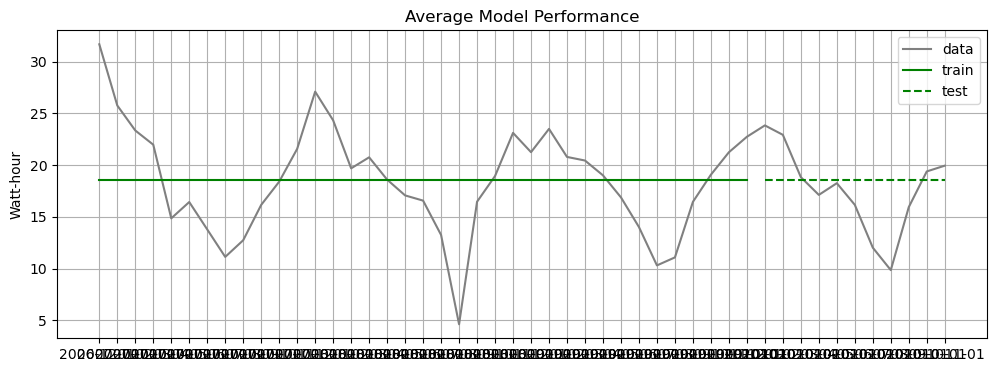

In [82]:
# Plot

plt.figure()

# Original time series
plt.plot(power_df_monthly['Energy Consumed by Household (Watt-hour)'], color='grey', label="data")

# Train and Test predictions
plt.plot(dates_train, mean_pred_train, color='green', label="train")
plt.plot(dates_test, mean_pred_test, color='green', ls="--", label="test")

plt.ylabel("Watt-hour")
plt.title(f"Average Model Performance")
plt.legend()
plt.show()

## Linear Regression Model with one Feature

In [83]:
first_day = power_df_monthly.index.min() # We get a string here
first_day = pd.to_datetime(first_day) # cahnging to time stamp
print(first_day)

2006-12-01 00:00:00


In [84]:
# Feature Engineering

# Ensure first_day is a Timestamp
first_day = pd.to_datetime(power_df_monthly.index.min())

# Ensure dates_train and dates_test are DatetimeIndex
dates_train_dt = pd.to_datetime(dates_train)
dates_test_dt = pd.to_datetime(dates_test)

# Create a numerical X feature that encodes the days from the start of the data
X_train = pd.DataFrame({"days_from_start": (dates_train_dt - first_day).days}, index=dates_train)
X_test = pd.DataFrame({"days_from_start": (dates_test_dt - first_day).days}, index=dates_test)

X_train.head()

,days_from_start
DateTime,
2006-12-01,0
2007-01-01,31
2007-02-01,62
2007-03-01,90
2007-04-01,121


In [85]:
first_day

Timestamp('2006-12-01 00:00:00')

In [86]:
y_train

DateTime
2006-12-01    31.688252
2007-01-01    25.767232
2007-02-01    23.351392
2007-03-01    21.977117
2007-04-01    14.853149
2007-05-01    16.431030
2007-06-01    13.780240
2007-07-01    11.122780
2007-08-01    12.736437
2007-09-01    16.155303
2007-10-01    18.398513
2007-11-01    21.574550
2007-12-01    27.107899
2008-01-01    24.332005
2008-02-01    19.689741
2008-03-01    20.755615
2008-04-01    18.599534
2008-05-01    17.071352
2008-06-01    16.568274
2008-07-01    13.246344
2008-08-01     4.608137
2008-09-01    16.461340
2008-10-01    18.946140
2008-11-01    23.117764
2008-12-01    21.253155
2009-01-01    23.503367
2009-02-01    20.792797
2009-03-01    20.445579
2009-04-01    19.011499
2009-05-01    16.880929
2009-06-01    14.012608
2009-07-01    10.302015
2009-08-01    11.076979
2009-09-01    16.447347
2009-10-01    19.074770
2009-11-01    21.245724
2009-12-01    22.740343
Name: Energy Consumed by Household (Watt-hour), dtype: float64

In [87]:
# Fit
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Predict
linreg_pred_train = linreg.predict(X_train)
linreg_pred_test = linreg.predict(X_test)

In [88]:
# Evaluate

summary_df.loc['linreg'] = [
    mean_absolute_error(y_train, linreg_pred_train),
    mean_absolute_error(y_test, linreg_pred_test),
    mean_absolute_percentage_error(y_train, linreg_pred_train),
    mean_absolute_percentage_error(y_test, linreg_pred_test)
]

summary_df

,Train_MAE,Test_MAE,Train_MAPE,Test_MAPE
baseline,4.034347,3.101882,0.292217,0.215832
linreg,4.077902,3.336767,0.294629,0.201769


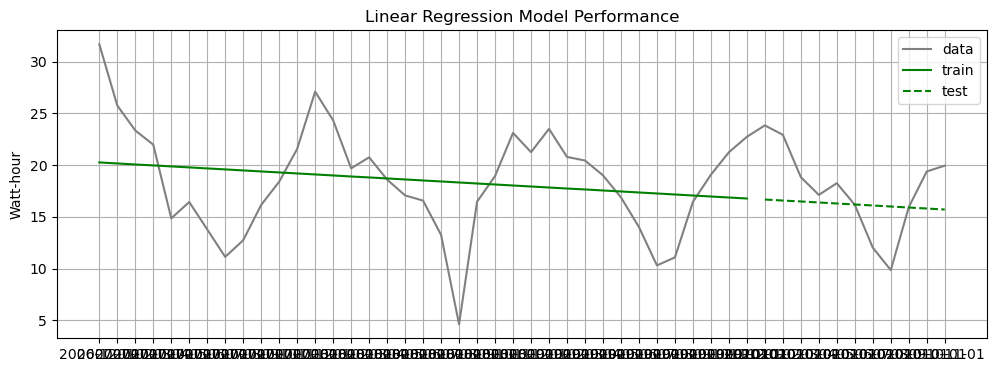

In [90]:
# Plot

plt.figure()

# Original time series
plt.plot(power_df_monthly['Energy Consumed by Household (Watt-hour)'], color='grey', label="data")

# Train and Test predictions
plt.plot(dates_train, linreg_pred_train, color='green', label="train")
plt.plot(dates_test, linreg_pred_test, color='green', ls="--", label="test")

plt.ylabel("Watt-hour")
plt.title(f"Linear Regression Model Performance")
plt.legend()
plt.show()

This looks slightly better  in  our visual intuition.  As you might expect, our model captures the overal trend of the data as a straight line with an downward slope.  Our evaluation metrics indicate that our model has an overall error of 4.077902	Watt-hour on average (MAE) for training data, but a lower error rate of 3.336767 Watt-hour for test data.  

__Note__: Notice how the errors are significantly lower for the test data than for train.  Normally, we think of this phenomenon as a consequence of underfittting, but here we see that our train data are systematically higher than our predictions.  Thus, there is some sort of trend in the data that we are not capturing. This is where we can perform additional feature engineering to further improve how we model the trend in our data.


## Linear regression model with Dataset Features

We will be using a linear regression  with data set model  to forecast the Energy Consumption 

In [91]:
power_df_monthly.head()

,Energy Consumed by Household (Watt-hour),"Energy Consumed by Household excluding sub-meterings 1, 2 and 3 (Watt-hour)",Reactive Energy Consumed by Household (Watt-hour),Voltage (volts),Global_intensity (amperes),Sub_metering_1 (watt-hours of active energy),Sub_metering_2 (watt-hours of active energy),Sub_metering_3 (watt-hours of active energy),temperature_2m (°C),relative_humidity_2m (%),dew_point_2m (°C),apparent_temperature (°C),surface_pressure (hPa),cloudcover (%),windspeed_10m (km/h),windgusts_10m (km/h),winddirection_10m (degrees),shortwave_radiation (W/m²),direct_radiation (W/m²),diffuse_radiation (W/m²)
DateTime,,,,,,,,,,,,,,,,,,,,
2006-12-01,31.688252,20.815071,2.189763,241.441125,8.029956,1.248636,2.214987,7.409558,2.665667,89.373203,1.035962,-1.077252,1020.453060,69.210094,12.331461,23.786715,122.629084,34.024386,14.111747,19.912639
2007-01-01,25.767232,15.343714,2.211268,240.905101,6.546915,1.264237,1.775931,7.383351,7.207161,84.024638,4.577192,3.423857,1010.176016,82.074769,17.715948,35.031811,211.768246,38.132655,15.181784,22.950871
2007-02-01,23.351392,13.865257,1.893946,240.519390,5.914569,1.180217,1.602361,6.703557,7.549305,82.832249,4.651629,3.992242,999.810829,79.073664,15.637397,31.425021,194.193422,73.579543,38.948361,34.631182
2007-03-01,21.977117,11.764254,1.912447,240.513469,5.572979,1.361343,2.346872,6.504648,7.257748,79.442310,3.707103,3.849526,1005.630479,59.874198,13.452050,27.374541,215.718411,124.956769,71.833233,53.123536
2007-04-01,14.853149,8.013774,1.979631,239.400026,3.825676,1.065886,0.973149,4.800339,13.788870,68.136852,7.520775,11.847011,1008.825148,30.560534,10.867634,22.397924,100.470444,248.593624,193.129412,55.464212


In [92]:
power_df_monthly.describe()

,Energy Consumed by Household (Watt-hour),"Energy Consumed by Household excluding sub-meterings 1, 2 and 3 (Watt-hour)",Reactive Energy Consumed by Household (Watt-hour),Voltage (volts),Global_intensity (amperes),Sub_metering_1 (watt-hours of active energy),Sub_metering_2 (watt-hours of active energy),Sub_metering_3 (watt-hours of active energy),temperature_2m (°C),relative_humidity_2m (%),dew_point_2m (°C),apparent_temperature (°C),surface_pressure (hPa),cloudcover (%),windspeed_10m (km/h),windgusts_10m (km/h),winddirection_10m (degrees),shortwave_radiation (W/m²),direct_radiation (W/m²),diffuse_radiation (W/m²)
count,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000
mean,18.321120,9.422480,2.061509,240.853692,4.659673,1.120904,1.303279,6.474457,11.097835,76.767556,6.780170,8.633018,1005.160287,66.144855,12.884849,26.332511,187.517946,133.072013,76.086800,56.985213
std,4.987339,3.445976,0.365125,1.557382,1.217717,0.337783,0.388811,1.534731,5.767715,7.465618,4.348617,6.944590,4.750157,10.637526,2.191422,4.024143,34.793938,74.391228,49.289738,27.425833
min,4.608137,2.237914,1.452726,235.178364,1.263569,0.086765,0.498768,1.784690,0.377776,59.941142,-1.924702,-3.599958,993.288873,30.560534,9.556192,19.955935,100.470444,32.427195,12.092424,17.800302
25%,16.101654,7.187932,1.825312,240.358281,4.143675,0.970355,1.059211,5.612713,6.539127,71.212382,3.284212,2.749192,1002.715357,59.328332,11.266892,23.446612,165.861148,59.388925,25.466342,29.399107
50%,18.717061,9.166583,2.081927,240.881698,4.713595,1.184714,1.255608,6.753966,11.201008,76.603554,7.157611,9.044142,1005.169229,67.703635,12.534104,25.893675,194.913579,135.312555,77.528870,57.870346
75%,21.333504,11.386313,2.195550,241.740022,5.361943,1.309756,1.605736,7.358702,16.443687,83.221395,10.782707,15.047268,1007.277731,74.258068,13.745306,27.824183,211.913739,207.961554,116.826427,84.495791
max,31.688252,20.815071,3.140427,244.082419,8.029956,1.696617,2.346872,10.211667,20.875234,89.373203,13.162610,20.503550,1020.453060,82.873264,19.174567,37.696269,263.282946,248.593624,193.129412,98.524133


In [118]:
# Pull out the X and y
X = power_df_monthly.drop('Energy Consumed by Household (Watt-hour)', axis=1)
y = power_df_monthly["Energy Consumed by Household (Watt-hour)"].copy()

In [119]:
X.head()

,"Energy Consumed by Household excluding sub-meterings 1, 2 and 3 (Watt-hour)",Reactive Energy Consumed by Household (Watt-hour),Voltage (volts),Global_intensity (amperes),Sub_metering_1 (watt-hours of active energy),Sub_metering_2 (watt-hours of active energy),Sub_metering_3 (watt-hours of active energy),temperature_2m (°C),relative_humidity_2m (%),dew_point_2m (°C),apparent_temperature (°C),surface_pressure (hPa),cloudcover (%),windspeed_10m (km/h),windgusts_10m (km/h),winddirection_10m (degrees),shortwave_radiation (W/m²),direct_radiation (W/m²),diffuse_radiation (W/m²)
DateTime,,,,,,,,,,,,,,,,,,,
2006-12-01,20.815071,2.189763,241.441125,8.029956,1.248636,2.214987,7.409558,2.665667,89.373203,1.035962,-1.077252,1020.453060,69.210094,12.331461,23.786715,122.629084,34.024386,14.111747,19.912639
2007-01-01,15.343714,2.211268,240.905101,6.546915,1.264237,1.775931,7.383351,7.207161,84.024638,4.577192,3.423857,1010.176016,82.074769,17.715948,35.031811,211.768246,38.132655,15.181784,22.950871
2007-02-01,13.865257,1.893946,240.519390,5.914569,1.180217,1.602361,6.703557,7.549305,82.832249,4.651629,3.992242,999.810829,79.073664,15.637397,31.425021,194.193422,73.579543,38.948361,34.631182
2007-03-01,11.764254,1.912447,240.513469,5.572979,1.361343,2.346872,6.504648,7.257748,79.442310,3.707103,3.849526,1005.630479,59.874198,13.452050,27.374541,215.718411,124.956769,71.833233,53.123536
2007-04-01,8.013774,1.979631,239.400026,3.825676,1.065886,0.973149,4.800339,13.788870,68.136852,7.520775,11.847011,1008.825148,30.560534,10.867634,22.397924,100.470444,248.593624,193.129412,55.464212


In [120]:
y.head()

DateTime
2006-12-01    31.688252
2007-01-01    25.767232
2007-02-01    23.351392
2007-03-01    21.977117
2007-04-01    14.853149
Name: Energy Consumed by Household (Watt-hour), dtype: float64

In [121]:
X.shape, y.shape

((48, 19), (48,))

we have 18 features to predict 1 target variable, so we are dealing with a multivariate regression problem

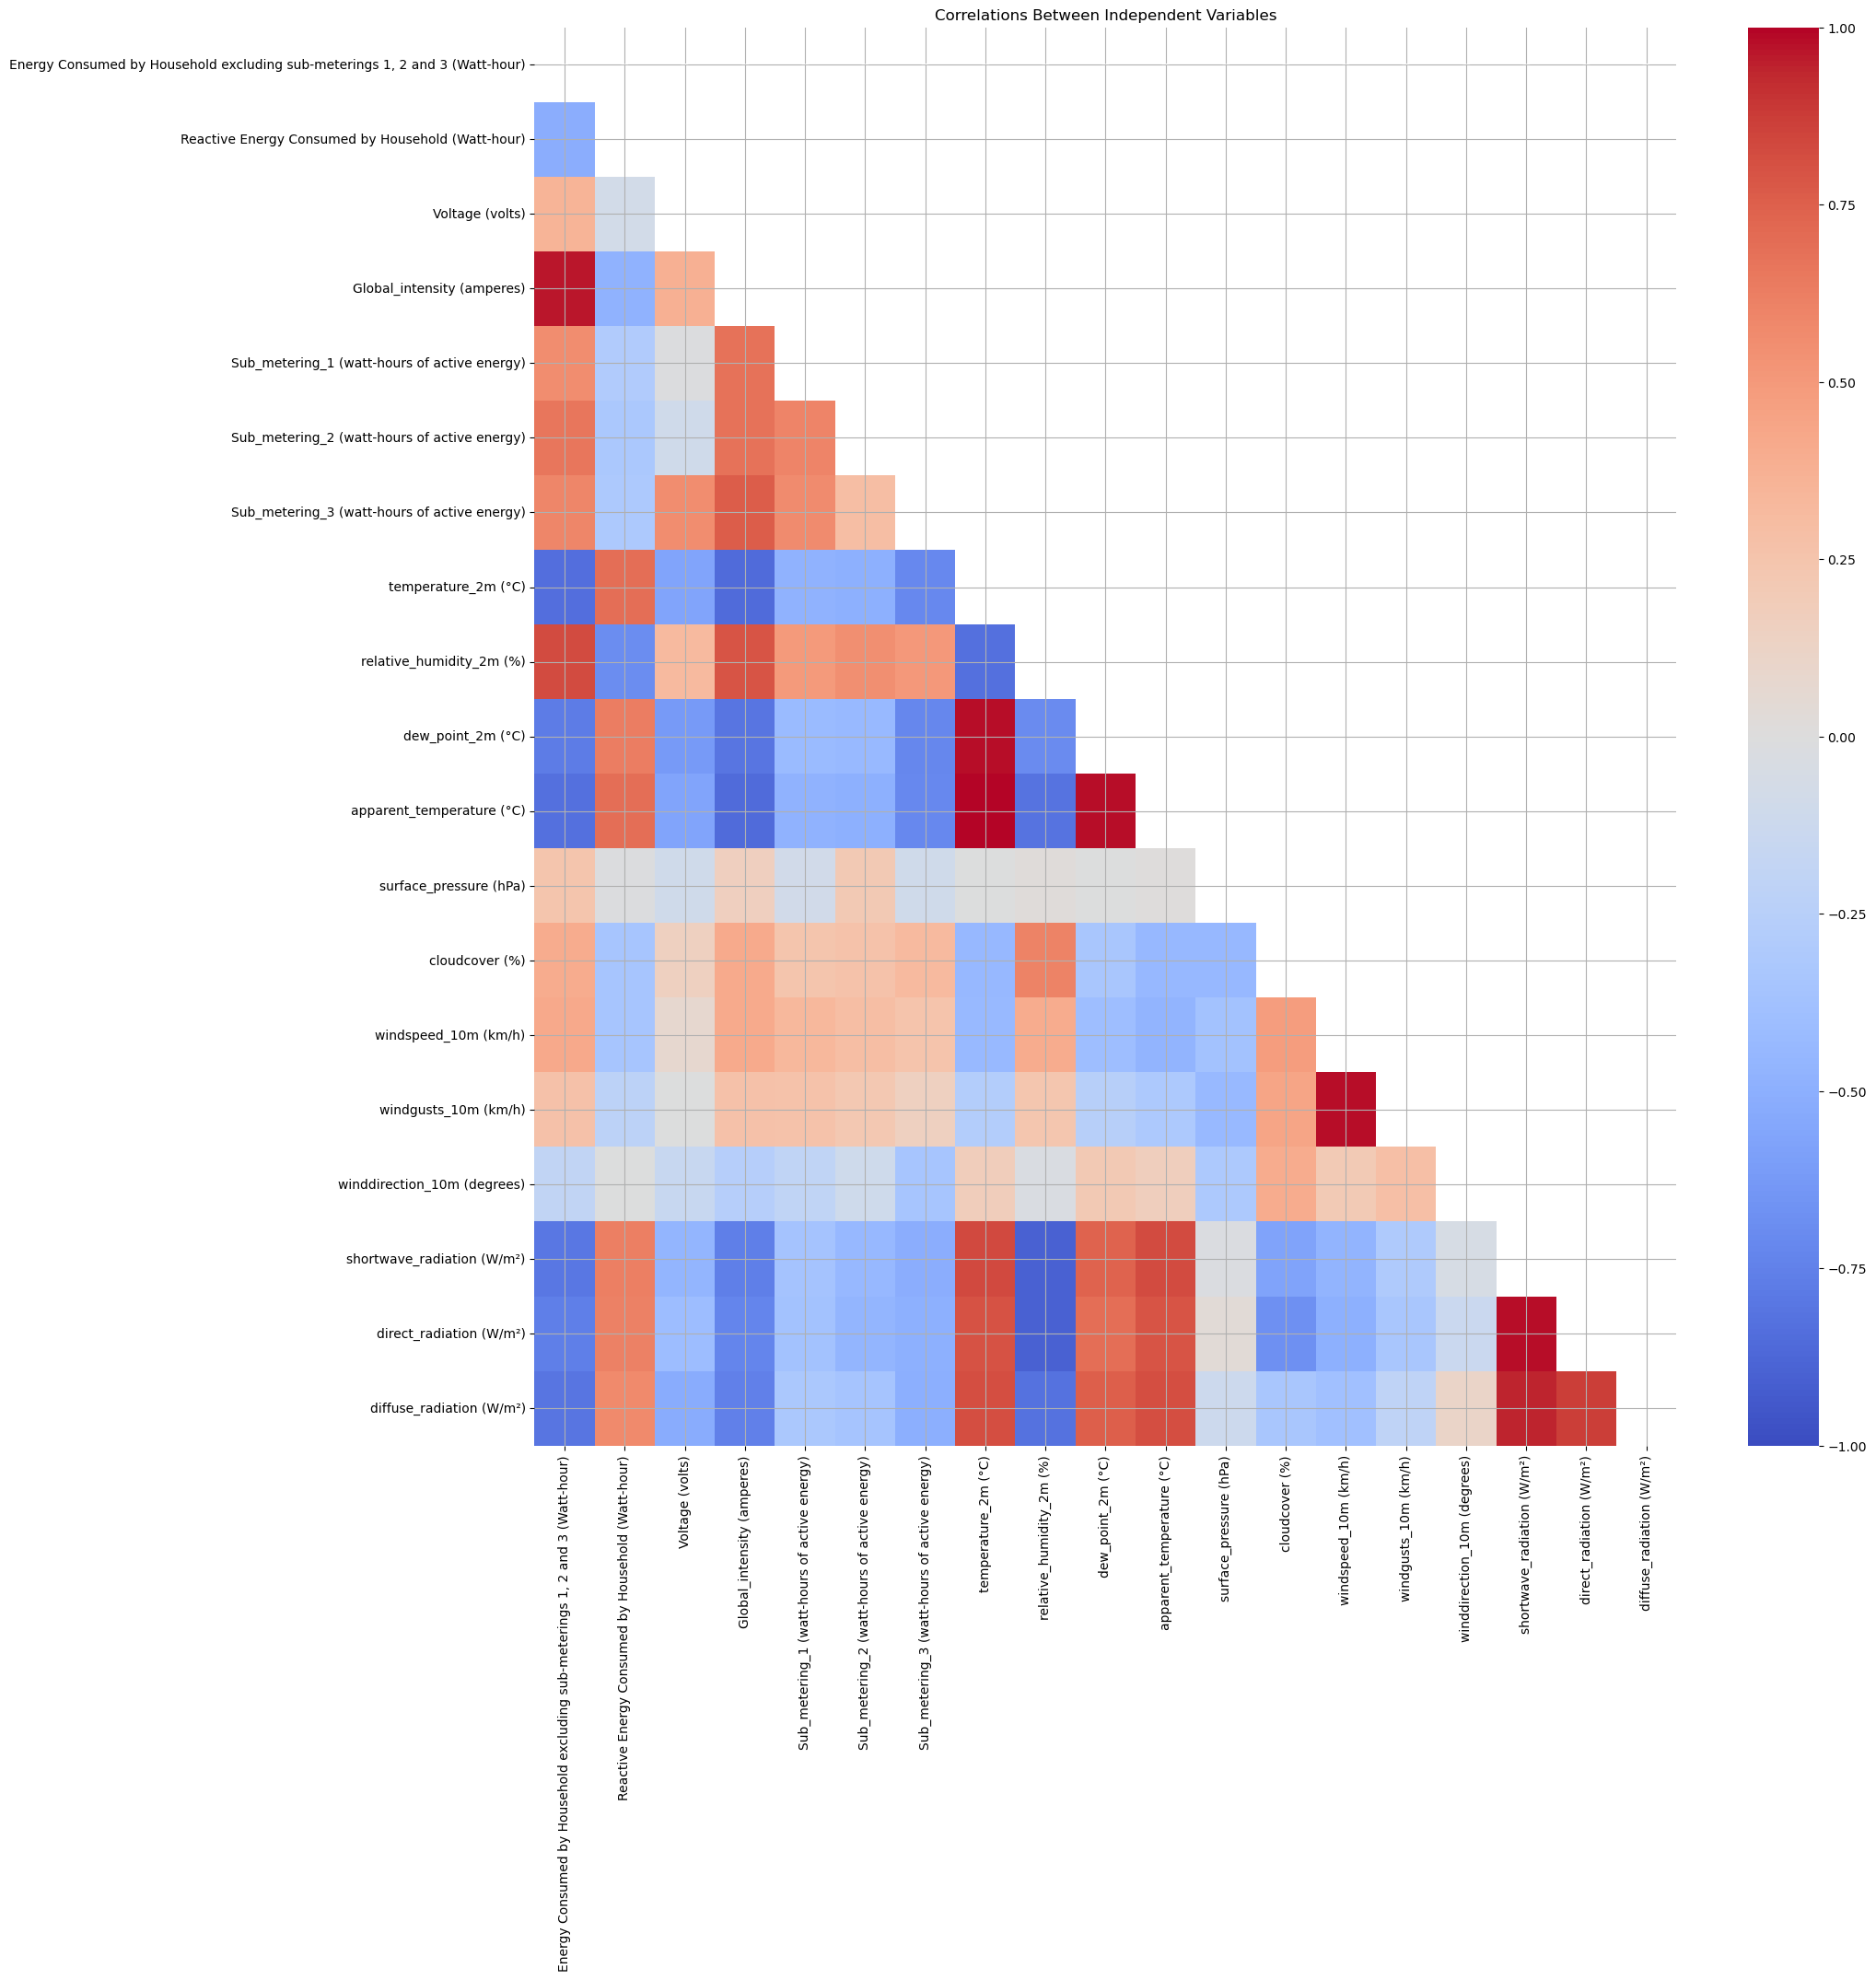

In [122]:
# Calculate all the correlations between each independent variable
corr_df = X.corr()

# Mask for upper-triangular
mask = np.triu(corr_df)

# Visualize with seaborn
plt.figure(figsize=(20, 20))
sns.heatmap(
    corr_df, 
    annot=True, 
    vmax=1, 
    vmin=-1, 
    center=0, 
    cmap="coolwarm", 
    mask=mask
)

plt.title("Correlations Between Independent Variables")
plt.show()

In [ ]:
#X.corr().abs().unstack().sort_values(ascending=False).head(30)

Energy Consumed by Household excluding sub-meterings 1, 2 and 3 (Watt-hour)  Energy Consumed by Household excluding sub-meterings 1, 2 and 3 (Watt-hour)    1.000000
apparent_temperature (°C)                                                    apparent_temperature (°C)                                                      1.000000
Global_intensity (amperes)                                                   Global_intensity (amperes)                                                     1.000000
Sub_metering_1 (watt-hours of active energy)                                 Sub_metering_1 (watt-hours of active energy)                                   1.000000
Sub_metering_2 (watt-hours of active energy)                                 Sub_metering_2 (watt-hours of active energy)                                   1.000000
Sub_metering_3 (watt-hours of active energy)                                 Sub_metering_3 (watt-hours of active energy)                                   1.000000
temperatur

If two independent variables are highly correlated (|r| ≥ 0.9 or so), I will only  keep just one of them.

Strong correlations I notice from the map:


`Temperature-related variables`

**temperature_2m ↔ apparent_temperature (almost perfect correlation, r ≈ 1)**

**temperature_2m ↔ dew_point_2m (very high correlation)**

**temperature_2m ↔ relative_humidity_2m (very high correlation)**

I will be keeping temperature_2m and drop apparent_temperatur and dew_point_2m, relative_humidiy_2m.

`Wind speed variables`

**windspeed_10m ↔ windgusts_10m (perfect correlation, r = 1)**

I will be keeping windspeed_10m,  but will drop windgusts_10m.

`Radiation variables`

**Shortwave_radiation ↔ direct_radiation (very high correlation)**

**Shortwave_radiation ↔ diffuse_radiation (high correlation)**

I will drop all 3  radiation variables as I  dont see any relation of them to power consumption interpretability.

`Global_intensity`

This essentially is highly corelated to Energy/Power as Power can be expressed as Voltage *Current (Intensity).

`Sub_metering variables`

Some correlations exist (e.g., Sub_metering_1 and Sub_metering_3 moderately correlated), but not as extreme — I will keep all of them as they are conceptually different.

Dropping variables for linear regression:

`apparent_temperature`

`dew_point_2m`

`relative_humidity_2m`

`windgusts_10m`

`direct_radiation` 

`diffuse_radiation`

` shortwave_radiation`



In [113]:
X.columns

Index(['Energy Consumed by Household excluding sub-meterings 1, 2 and 3 (Watt-hour)',
       'Reactive Energy Consumed by Household (Watt-hour)', 'Voltage (volts)',
       'Global_intensity (amperes)',
       'Sub_metering_1 (watt-hours of active energy)',
       'Sub_metering_2 (watt-hours of active energy)',
       'Sub_metering_3 (watt-hours of active energy)', 'temperature_2m (°C)',
       'relative_humidity_2m (%)', 'dew_point_2m (°C)',
       'apparent_temperature (°C)', 'surface_pressure (hPa)', 'cloudcover (%)',
       'windspeed_10m (km/h)', 'windgusts_10m (km/h)',
       'winddirection_10m (degrees)', 'shortwave_radiation (W/m²)',
       'direct_radiation (W/m²)', 'diffuse_radiation (W/m²)'],
      dtype='object')

In [127]:
# Drop the identified columns
cols_to_drop = ["apparent_temperature (°C)", "dew_point_2m (°C)", "relative_humidity_2m (%)","windspeed_10m (km/h)", "direct_radiation (W/m²)", "diffuse_radiation (W/m²)", "shortwave_radiation (W/m²)"]
X.drop(cols_to_drop, axis=1, inplace=True)


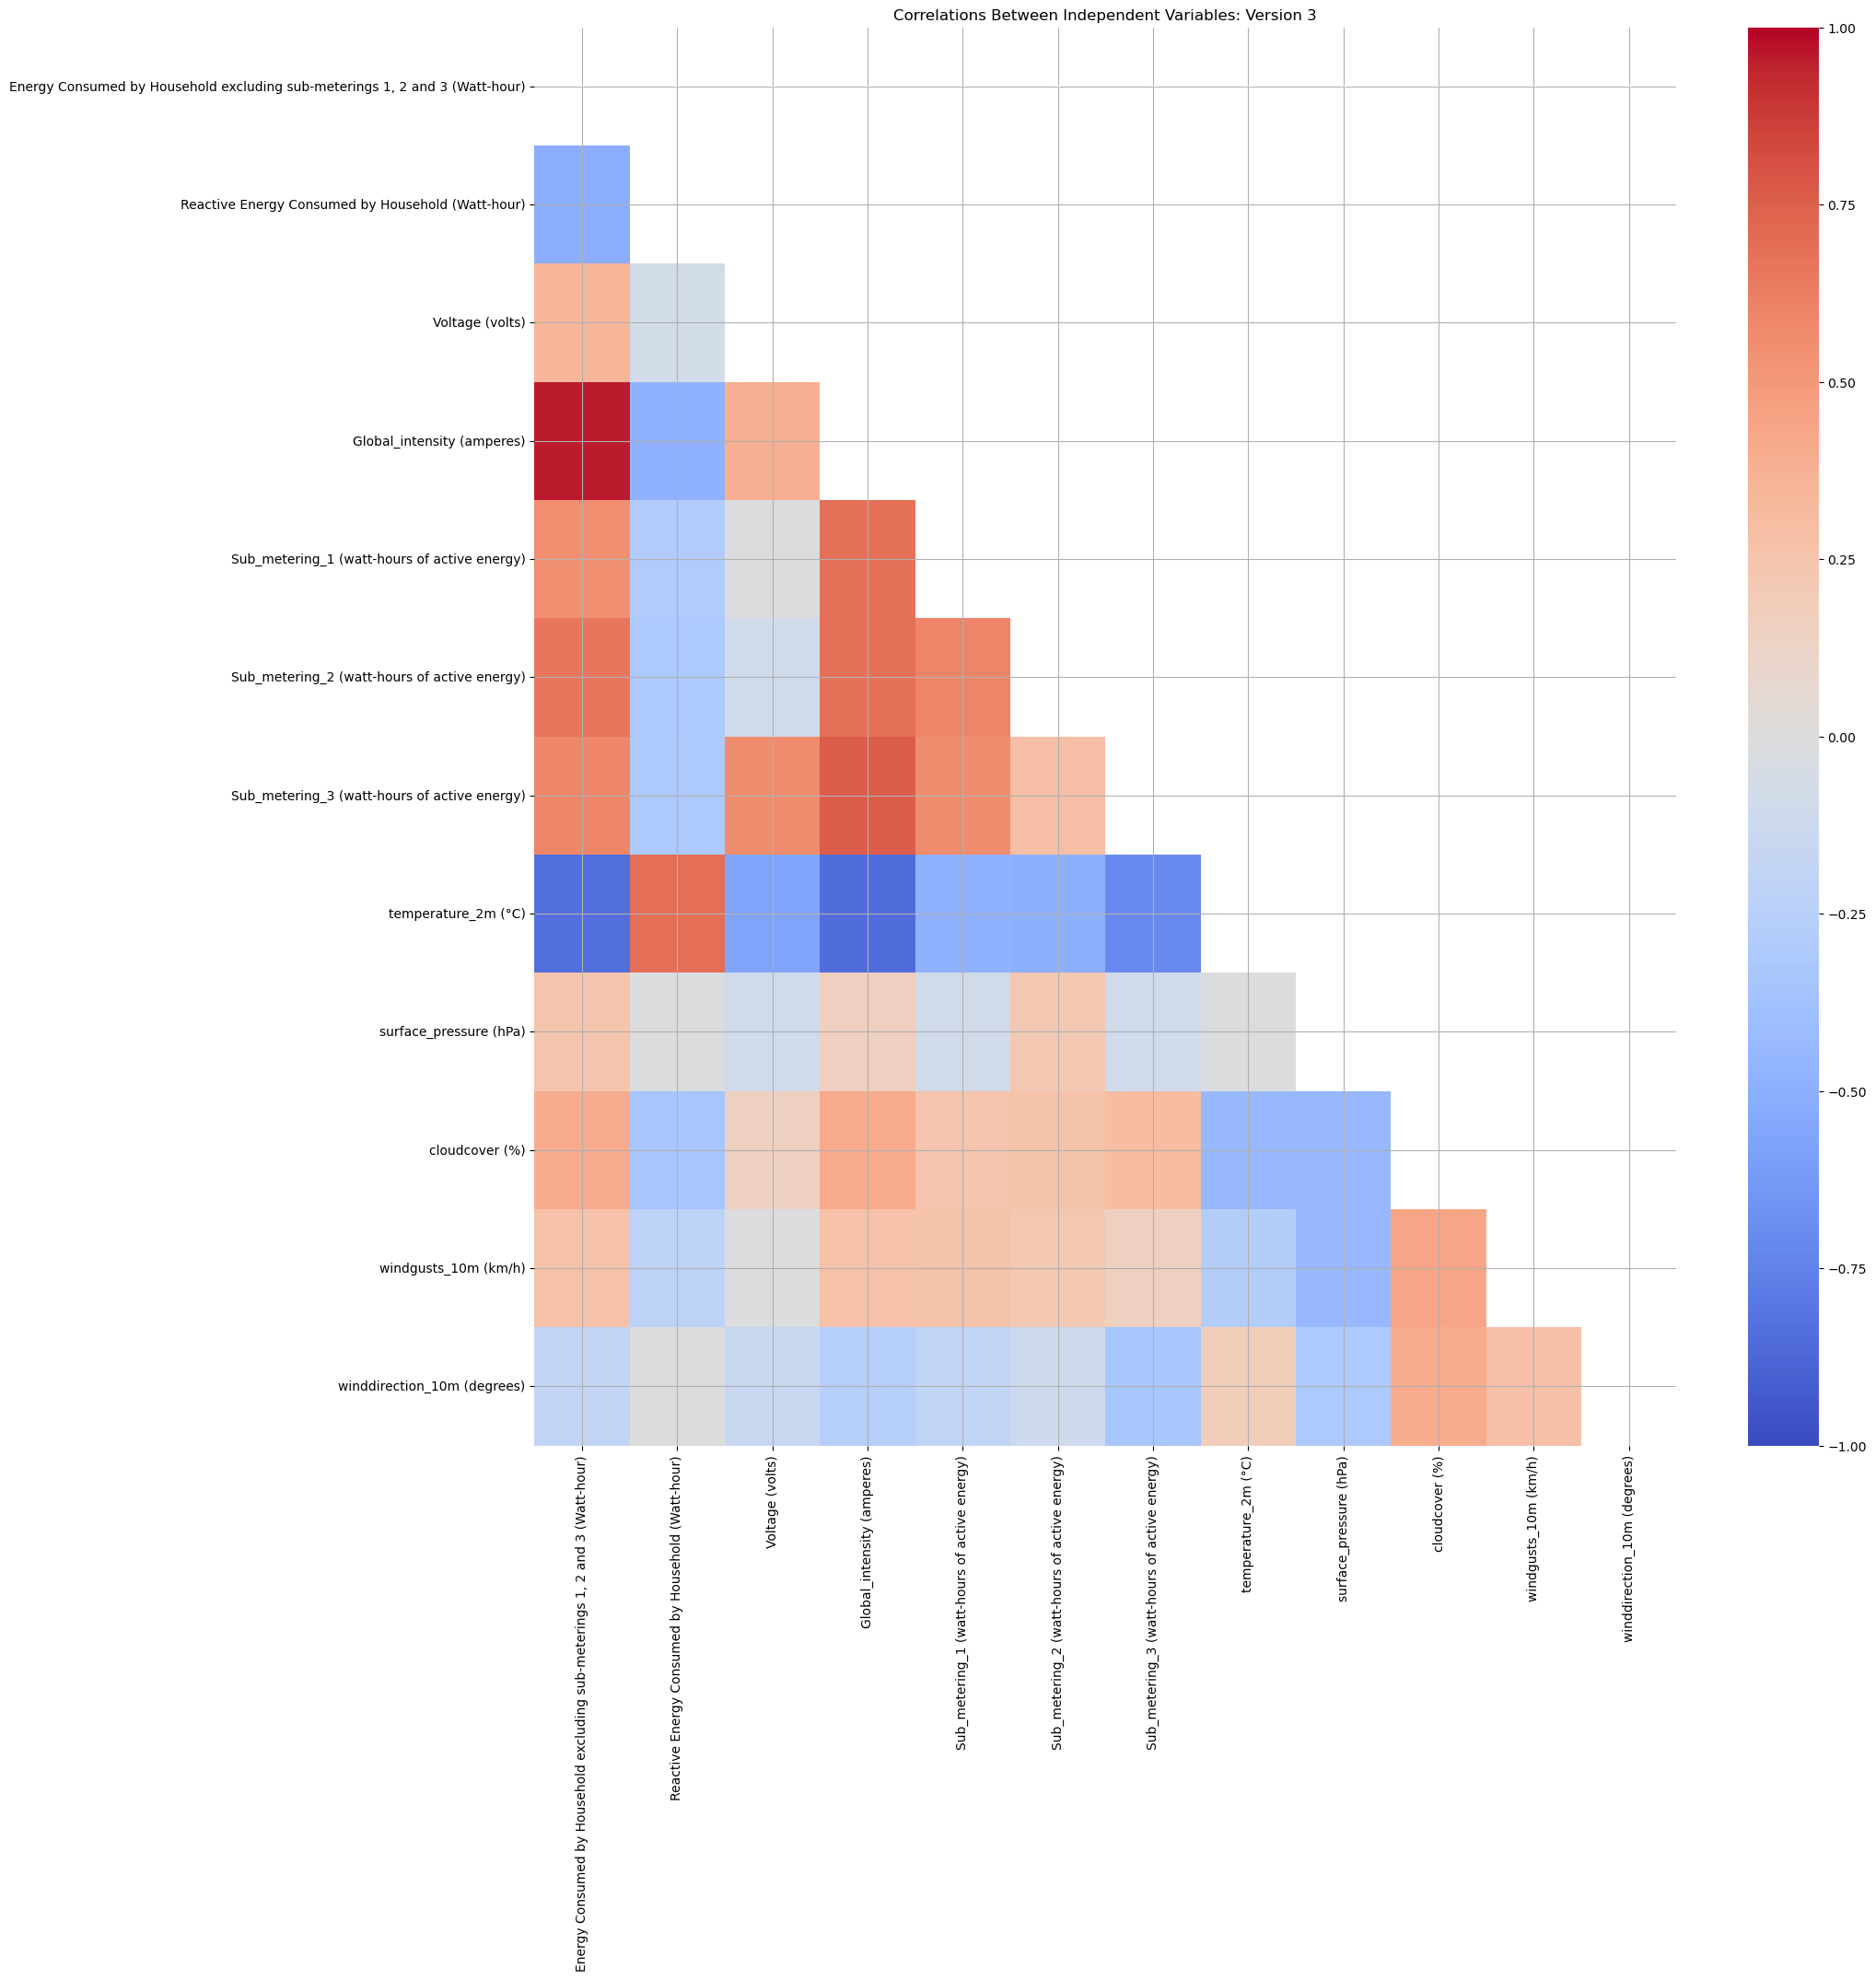

In [128]:
#checking the correlations again after dropping the columns
# Calculate all the correlations between each independent variable
corr_df = X.corr()

# Mask for upper-triangular
mask = np.triu(corr_df)

# Visualize with seaborn
plt.figure(figsize=(20, 20))
sns.heatmap(
    corr_df.round(2), 
    annot=True, 
    vmax=1, 
    vmin=-1, 
    center=0, 
    cmap="coolwarm", 
    mask=mask
)

plt.title("Correlations Between Independent Variables: Version 3")
plt.show()

In [129]:
X.corr()

,"Energy Consumed by Household excluding sub-meterings 1, 2 and 3 (Watt-hour)",Reactive Energy Consumed by Household (Watt-hour),Voltage (volts),Global_intensity (amperes),Sub_metering_1 (watt-hours of active energy),Sub_metering_2 (watt-hours of active energy),Sub_metering_3 (watt-hours of active energy),temperature_2m (°C),surface_pressure (hPa),cloudcover (%),windgusts_10m (km/h),winddirection_10m (degrees)
"Energy Consumed by Household excluding sub-meterings 1, 2 and 3 (Watt-hour)",1.000000,-0.510950,0.351794,0.963761,0.554835,0.656542,0.589427,-0.836035,0.247341,0.399580,0.268875,-0.191051
Reactive Energy Consumed by Household (Watt-hour),-0.510950,1.000000,-0.081791,-0.482688,-0.291068,-0.324462,-0.313198,0.693360,-0.010622,-0.348608,-0.223669,-0.002274
Voltage (volts),0.351794,-0.081791,1.000000,0.381070,-0.013803,-0.098671,0.558225,-0.565691,-0.098016,0.149484,-0.006317,-0.150468
Global_intensity (amperes),0.963761,-0.482688,0.381070,1.000000,0.679535,0.675055,0.762947,-0.854030,0.163531,0.406330,0.266535,-0.259466
Sub_metering_1 (watt-hours of active energy),0.554835,-0.291068,-0.013803,0.679535,1.000000,0.597398,0.563245,-0.479020,-0.091803,0.248150,0.260052,-0.199976
Sub_metering_2 (watt-hours of active energy),0.656542,-0.324462,-0.098671,0.675055,0.597398,1.000000,0.294731,-0.499263,0.215136,0.260964,0.220475,-0.107279
Sub_metering_3 (watt-hours of active energy),0.589427,-0.313198,0.558225,0.762947,0.563245,0.294731,1.000000,-0.712922,-0.100294,0.313875,0.148678,-0.347899
temperature_2m (°C),-0.836035,0.693360,-0.565691,-0.854030,-0.479020,-0.499263,-0.712922,1.000000,-0.005882,-0.439816,-0.275216,0.179325
surface_pressure (hPa),0.247341,-0.010622,-0.098016,0.163531,-0.091803,0.215136,-0.100294,-0.005882,1.000000,-0.443874,-0.437020,-0.319993
cloudcover (%),0.399580,-0.348608,0.149484,0.406330,0.248150,0.260964,0.313875,-0.439816,-0.443874,1.000000,0.443604,0.400259


I dont why my correlator matrix is not showing all the values. I tried everything, so i use a table to see the actual values

So we can see that submetering_3 has by far the largest variance. Lets now scale the data. We will be using the Standard  scaler here 

In [130]:
corr_df = X.corr()

corr_df

,"Energy Consumed by Household excluding sub-meterings 1, 2 and 3 (Watt-hour)",Reactive Energy Consumed by Household (Watt-hour),Voltage (volts),Global_intensity (amperes),Sub_metering_1 (watt-hours of active energy),Sub_metering_2 (watt-hours of active energy),Sub_metering_3 (watt-hours of active energy),temperature_2m (°C),surface_pressure (hPa),cloudcover (%),windgusts_10m (km/h),winddirection_10m (degrees)
"Energy Consumed by Household excluding sub-meterings 1, 2 and 3 (Watt-hour)",1.000000,-0.510950,0.351794,0.963761,0.554835,0.656542,0.589427,-0.836035,0.247341,0.399580,0.268875,-0.191051
Reactive Energy Consumed by Household (Watt-hour),-0.510950,1.000000,-0.081791,-0.482688,-0.291068,-0.324462,-0.313198,0.693360,-0.010622,-0.348608,-0.223669,-0.002274
Voltage (volts),0.351794,-0.081791,1.000000,0.381070,-0.013803,-0.098671,0.558225,-0.565691,-0.098016,0.149484,-0.006317,-0.150468
Global_intensity (amperes),0.963761,-0.482688,0.381070,1.000000,0.679535,0.675055,0.762947,-0.854030,0.163531,0.406330,0.266535,-0.259466
Sub_metering_1 (watt-hours of active energy),0.554835,-0.291068,-0.013803,0.679535,1.000000,0.597398,0.563245,-0.479020,-0.091803,0.248150,0.260052,-0.199976
Sub_metering_2 (watt-hours of active energy),0.656542,-0.324462,-0.098671,0.675055,0.597398,1.000000,0.294731,-0.499263,0.215136,0.260964,0.220475,-0.107279
Sub_metering_3 (watt-hours of active energy),0.589427,-0.313198,0.558225,0.762947,0.563245,0.294731,1.000000,-0.712922,-0.100294,0.313875,0.148678,-0.347899
temperature_2m (°C),-0.836035,0.693360,-0.565691,-0.854030,-0.479020,-0.499263,-0.712922,1.000000,-0.005882,-0.439816,-0.275216,0.179325
surface_pressure (hPa),0.247341,-0.010622,-0.098016,0.163531,-0.091803,0.215136,-0.100294,-0.005882,1.000000,-0.443874,-0.437020,-0.319993
cloudcover (%),0.399580,-0.348608,0.149484,0.406330,0.248150,0.260964,0.313875,-0.439816,-0.443874,1.000000,0.443604,0.400259


### <a id='toc5_3_'></a>Detecting Multicollinearity With Variance Inflation Factors [&#8593;](#toc0_)

Looking only at correlations won't detect multicollinearity, hence we need a new tool: the **Variance Inflation Factor** (VIF). 

In order to calculate it, we build a regression model of each independent variable against the other independent variables and look at the $R^2$ score. The VIF for each predictor is defined as 
$$
\text{VIF}_i = \frac{1}{1-R_i^2}
$$

In a perfect scenario of no multicollinearity, the VIF for each predictor should be 1 (since the $R^2$ from each model would be 0, showing that the given independent variable can't be modeled by the other variables, hence no linear relationship). 

By common convention, any VIF value higher than 5 indicates high multicollinearity. Let's examine the VIF for the variables in our dataset:

In [131]:
# Adding the constant to the features 
X_with_const = sm.add_constant(X)
X_with_const.head()

,const,"Energy Consumed by Household excluding sub-meterings 1, 2 and 3 (Watt-hour)",Reactive Energy Consumed by Household (Watt-hour),Voltage (volts),Global_intensity (amperes),Sub_metering_1 (watt-hours of active energy),Sub_metering_2 (watt-hours of active energy),Sub_metering_3 (watt-hours of active energy),temperature_2m (°C),surface_pressure (hPa),cloudcover (%),windgusts_10m (km/h),winddirection_10m (degrees)
DateTime,,,,,,,,,,,,,
2006-12-01,1.0,20.815071,2.189763,241.441125,8.029956,1.248636,2.214987,7.409558,2.665667,1020.453060,69.210094,23.786715,122.629084
2007-01-01,1.0,15.343714,2.211268,240.905101,6.546915,1.264237,1.775931,7.383351,7.207161,1010.176016,82.074769,35.031811,211.768246
2007-02-01,1.0,13.865257,1.893946,240.519390,5.914569,1.180217,1.602361,6.703557,7.549305,999.810829,79.073664,31.425021,194.193422
2007-03-01,1.0,11.764254,1.912447,240.513469,5.572979,1.361343,2.346872,6.504648,7.257748,1005.630479,59.874198,27.374541,215.718411
2007-04-01,1.0,8.013774,1.979631,239.400026,3.825676,1.065886,0.973149,4.800339,13.788870,1008.825148,30.560534,22.397924,100.470444


In [132]:
VIF_values = pd.Series(
    data=[variance_inflation_factor(X_with_const, i) for i in range(X_with_const.shape[1])],
    index=X_with_const.columns
)

VIF_values[1:] # Slicing to leave out the constant

Energy Consumed by Household excluding sub-meterings 1, 2 and 3 (Watt-hour)    4705.510146
Reactive Energy Consumed by Household (Watt-hour)                                 5.503484
Voltage (volts)                                                                   7.655574
Global_intensity (amperes)                                                     9108.616178
Sub_metering_1 (watt-hours of active energy)                                     57.306406
Sub_metering_2 (watt-hours of active energy)                                     58.062541
Sub_metering_3 (watt-hours of active energy)                                    827.219265
temperature_2m (°C)                                                              18.216210
surface_pressure (hPa)                                                            3.391160
cloudcover (%)                                                                    2.804824
windgusts_10m (km/h)                                                              1.747547

A high VIF means that the independent variable in question has a higher level of multi-collinearity with the other independent variables.

An obvious step would be to just drop the columns with the highest VIF numbers. One thing to note however is that dropping one variable will change the VIFs for *all the independent variables*.

For our case, as we see above many of our remaining variables has a VIF greater then 5. This means we have to drop these.

In [142]:
X.drop(columns=['Energy Consumed by Household excluding sub-meterings 1, 2 and 3 (Watt-hour)', 'Global_intensity (amperes)', 'Sub_metering_1 (watt-hours of active energy)','Sub_metering_2 (watt-hours of active energy)','Sub_metering_3 (watt-hours of active energy)','temperature_2m (°C)'], inplace=True)

In [143]:
X_train = X.loc[dates_train]
X_test = X.loc[dates_test]

In [144]:
X_train.head()

,Reactive Energy Consumed by Household (Watt-hour),Voltage (volts),surface_pressure (hPa),cloudcover (%),windgusts_10m (km/h),winddirection_10m (degrees)
DateTime,,,,,,
2006-12-01,2.189763,241.441125,1020.453060,69.210094,23.786715,122.629084
2007-01-01,2.211268,240.905101,1010.176016,82.074769,35.031811,211.768246
2007-02-01,1.893946,240.519390,999.810829,79.073664,31.425021,194.193422
2007-03-01,1.912447,240.513469,1005.630479,59.874198,27.374541,215.718411
2007-04-01,1.979631,239.400026,1008.825148,30.560534,22.397924,100.470444


In [145]:
X_test.head()

,Reactive Energy Consumed by Household (Watt-hour),Voltage (volts),surface_pressure (hPa),cloudcover (%),windgusts_10m (km/h),winddirection_10m (degrees)
DateTime,,,,,,
2010-01-01,2.086323,243.455510,1004.682451,76.546685,21.805420,173.977681
2010-02-01,1.707351,242.348111,993.288873,79.196160,32.182581,167.217636
2010-03-01,2.084247,241.993211,1006.384237,67.692430,29.951941,167.933579
2010-04-01,2.080848,241.782798,1007.753289,52.417401,26.779100,136.224137
2010-05-01,2.036416,240.369171,1004.779938,64.297257,27.264906,168.308419


In [146]:
# Fit
linreg_features = LinearRegression()
linreg_features.fit(X_train, y_train)

# Predict
linreg_features_pred_train = linreg_features.predict(X_train)
linreg_features_pred_test = linreg_features.predict(X_test)

In [147]:
# Evaluate

summary_df.loc['linreg_features'] = [
    mean_absolute_error(y_train, linreg_features_pred_train),
    mean_absolute_error(y_test, linreg_features_pred_test),
    mean_absolute_percentage_error(y_train, linreg_features_pred_train),
    mean_absolute_percentage_error(y_test, linreg_features_pred_test)
]

summary_df

,Train_MAE,Test_MAE,Train_MAPE,Test_MAPE
baseline,4.034347,3.101882,0.292217,0.215832
linreg,4.077902,3.336767,0.294629,0.201769
linreg_features,2.161182,2.252246,0.173624,0.143655


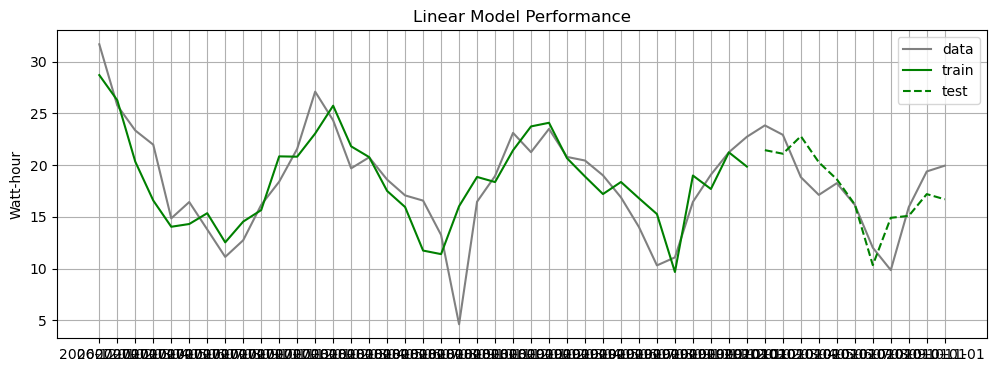

In [149]:
# Plot

plt.figure()

# Original time series
plt.plot(power_df_monthly['Energy Consumed by Household (Watt-hour)'], color='grey', label="data")

# Train and Test predictions
plt.plot(dates_train, linreg_features_pred_train, color='green', label="train")
plt.plot(dates_test, linreg_features_pred_test, color='green', ls="--", label="test")

plt.ylabel("Watt-hour")
plt.title(f"Linear Model Performance")
plt.legend()
plt.show()

<div style="padding: 10px; border: 2px #000000 solid; background: #F6F6F4">

<span style="color:#1358DB; font-weight:bold;">ΑRΜΑ</span>

ARMA stands for Autoregressive Moving Average model and it is a family of statistical models that were built specifically for time series
analysis and forecasting. ARMA models are made up of two core components:

- `AR`: This is the autoregressive component. It performes regression using past values, just like we showed above. The number of past values that will be used is specified using the hyperpatameter p.
  
- `MA`: This is the moving average component. It calculates the weighted sum of the past forecasting errors. The number of previous forecast errors that will be considered is specified using the hyperpatameter q.

</div>

In [150]:
# Fit
arima_310 = SARIMAX(y_train, order=(3, 1, 0)).fit(disp=0)

# Predict
arima_310_pred_train = arima_310.predict(dates_train.min(), dates_train.max())
arima_310_pred_test = arima_310.predict(dates_test.min(), dates_test.max())

In [151]:
# Evaluate

summary_df.loc['arima_310'] = [
    mean_absolute_error(y_train, arima_310_pred_train),
    mean_absolute_error(y_test, arima_310_pred_test),
    mean_absolute_percentage_error(y_train, arima_310_pred_train),
    mean_absolute_percentage_error(y_test, arima_310_pred_test)
]

summary_df

,Train_MAE,Test_MAE,Train_MAPE,Test_MAPE
baseline,4.034347,3.101882,0.292217,0.215832
linreg,4.077902,3.336767,0.294629,0.201769
linreg_features,2.161182,2.252246,0.173624,0.143655
arima_310,3.804520,5.681836,0.232319,0.404555


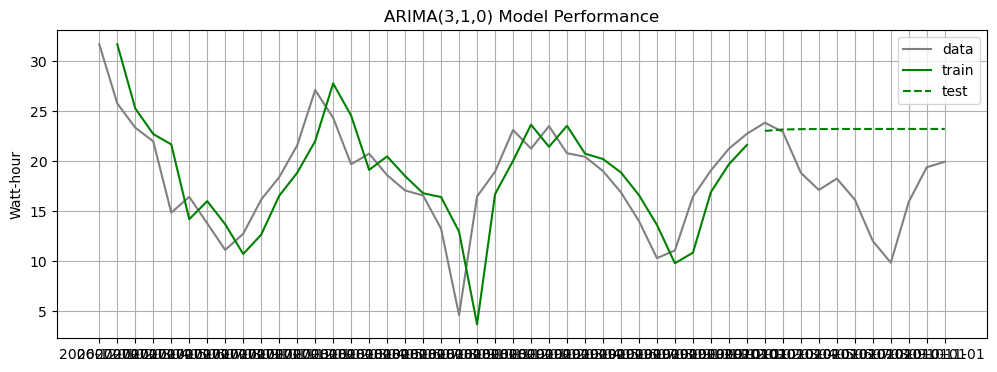

In [153]:
plt.figure()

# Original time series
plt.plot(y, color='grey', label="data")

# Train and test predictions
plt.plot(dates_train[1:], arima_310_pred_train[1:], color='green', label="train")
plt.plot(dates_test, arima_310_pred_test, color='green', ls="--", label="test")

plt.ylabel("Watt-hour")
plt.title(f"ARIMA(3,1,0) Model Performance")
plt.legend()
plt.show()